# Машинное обучение, ФКН ВШЭ

# Практическое задание 7. Бустинговое

## Общая информация

Дата выдачи: 06.12.2021

Мягкий дедлайн: 18.12.2021 23:59 MSK

Жёсткий дедлайн: 19.12.2021 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг.

In [1]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split, GridSearchCV
import random

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample


sns.set(style='darkgrid')
filterwarnings('ignore')

In [2]:
x = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 1337 для воспроизводимости).

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга (4 балла)

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

В `__init__` приходит кучка параметров, распишем что есть что:

 - `base_model_class` - класс базовой модели нашего бустинга
 - `base_model_params` - словарь с гиперпараметрами для базовой модели
 - `n_estimators` - какое количество базовых моделей нужно обучить
 - `learning_rate` - темп обучения, должен быть из полуинтервала $(0, 1]$
 - `subsample` - доля объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей)
 - `early_stopping_rounds` - число итераций, после которых при отсутствии улучшения качества на валидационной выборке обучение останавливается
 - `plot` - строить ли после обучения всех базовых моделей график с качеством

#### `fit`

В `fit` приходит две выборки, обучающая и валидационная. На обучающей мы обучаем новые базовые модели, на валидационной считаем качество для ранней остановки (если это предусматривают параметры).

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания для обучающей и валидационной выборок (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на обучающей и валидационной выборках (используем `loss_fn` для этого), проверить на раннюю остановку.

После всего цикла обучения надо нарисовать график (если `plot`).


#### `fit_new_base_model`

В `fit_new_base_model` приходит обучающая выборка (целиком) и текущие предсказания для неё. Мы должны сгенерировать бутстрап выборку для обучения базовой модели и обучить базовую модель. После обучения модели запускаем поиск оптимальной гаммы, добавляем новую модель и гамму (не забываем про темп обучения) в соответствующие списки.

#### `predict_proba`

В `predict_proba` приходит выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду.

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

In [61]:
boosting = Boosting()

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

CPU times: user 1.8 s, sys: 32.9 ms, total: 1.84 s
Wall time: 1.92 s
Train ROC-AUC 0.9897
Valid ROC-AUC 0.9086
Test ROC-AUC 0.9102


## Задание 2. Обучение градиентного бустинга (1 балл)

Оцените качество на тестовой выборке вашей имплементации бустинга для различной максимальной глубины решающего дерева в качестве базовой модели. Здесь и далее мы будем использовать метрику ROC-AUC.

Перебирайте максимальную глубину от 1 до 30 с шагом 2 (остальные параметры бустинга стоит оставить равными по умолчанию). Постройте график зависимости качества на обучающей и тестовой выборке в зависимости от глубины.

In [62]:
results = {'train': [], 'test': []}

depths = range(1, 30, 2)

for depth in depths:
    boosting = Boosting(base_model_params = {'max_depth': depth})
    boosting.fit(x_train, y_train, x_test, y_test)
    results['train'].append(boosting.score(x_train, y_train))
    results['test'].append(boosting.score(x_test, y_test))

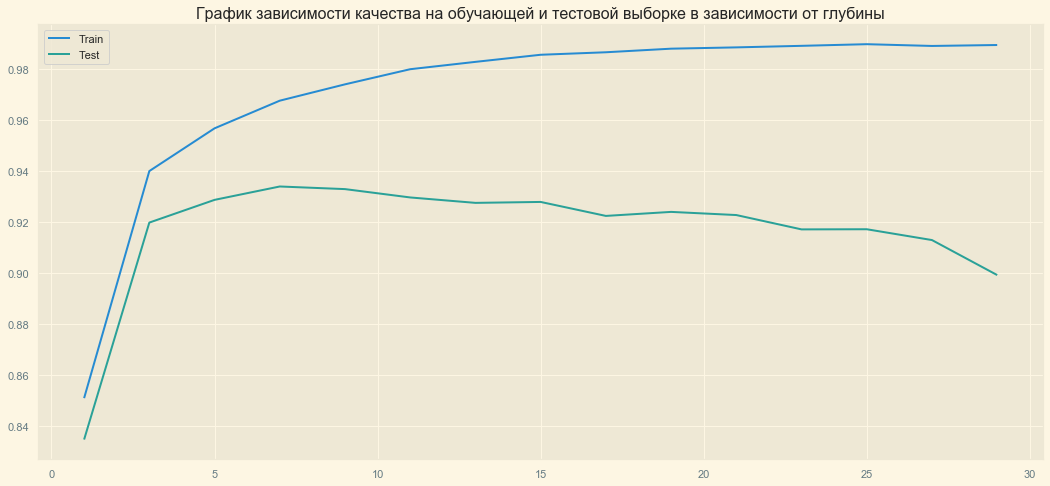

In [133]:
plt.style.use('Solarize_Light2')

plt.figure(figsize=(18, 8))
sns.lineplot(depths, results['train'], label='Train')
sns.lineplot(depths, results['test'], label='Test')
plt.title('График зависимости качества на обучающей и тестовой выборке в зависимости от глубины')
plt.legend()
plt.show()

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

1. Очевидным образом лучше обучающая модель. При этом схожесть поведения двух показателей оказывается достаточно изменчивой. Изначально демонстрируя резкий рост значения `ROC-AUC`, мы видим достижение тестовых значений максимума при `depth` лежащим в интервале от 7 до 9. После идет планоменое падение, определяющее весь тренд на бесконечности. В свою очередь, показатели бустинга на обучающей выборке беспрестанно растут.


2. Связаны все вышеперечисленные события с тем, что чрезмерный рост глубины "по дефолту" приводит к переобучению решеющего дерева, способного в итоге индивидуально подходить к каждому значению. Variance растет, bias падает. В итоге мы очень сильно подбираемся к индивидуальной обработке значений лишь из обучающей выборки.

## Задание 3. Подбираем гиперпараметры и ищем лучшую модель (2 балла)

Подберите по валидационной выборке основные гиперпараметры для вашей модели бустинга. Следует подобрать все основные параметры для самого градиентного бустинга и для самих базовых моделей.

In [77]:
from tqdm import tqdm_notebook

best_score = 0
best_params = []
for i in tqdm_notebook(range(20)):
    cur_tree_params = {
         'max_depth' : random.choice([7, 9, 12, 15]),
         'min_samples_leaf' : random.choice([1, 2, 3])
    }
    cur_params = {  
                'learning_rate' : random.choice([0.01, 0.05, 0.1]),
                'n_estimators'    : random.choice([70, 90, 100]),
                'early_stopping_rounds' : random.choice([30, 70, 100]),
                'subsample' : random.choice([0.1, 0.3, 0.5])
            }
    boosting = Boosting(**cur_params, base_model_params=cur_tree_params)
    boosting.fit(x_train, y_train, x_valid, y_valid)
    attempt = boosting.history.iloc[-1, 1]
    if attempt > best_score :
        best_score = attempt
        best_params = [cur_tree_params, cur_params]

In [208]:
pd.DataFrame(pd.DataFrame(best_params).sum(axis=0), columns=['best value'])

,best value
max_depth,7.0
min_samples_leaf,1.0
learning_rate,0.1
n_estimators,100.0
early_stopping_rounds,30.0
subsample,0.1


In [192]:
print('Hand-crafted Selection of hyperparameters')
print('ROC-AUC score on test for the Best combination is,', best_score)

Hand-crafted Selection of hyperparameters
ROC-AUC score on test for the Best combination is, 0.9404661275684788


## Задание 4. Пробуем разные библиотеки (2 балла)

Выберите себе библиотеку с реализацией градиентного бустинга по вкусу из следующих трёх - [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html), [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html), [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart). Подберите основные гиперпараметры, постарайтесь добиться наилучшего качества на тестовых данных. Сравните результаты своей реализации с результатами библиотечного бустинга.

In [196]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import PredefinedSplit


spec = {
    'loss_function' : 'Logloss',
    'eval_metric' : 'AUC:hints=skip_train~false',
    'logging_level' : 'Silent',
    'metric_period' : 50
}


model = CatBoostClassifier(**spec)
parameters = {  'depth' : [5, 7,  9],
                'learning_rate' : [0.001, 0.005, 0.01],
                'n_estimators'     : np.arange(40, 90, 20),
                'boosting_type' : ["Ordered", "Plain"],
                'min_data_in_leaf' : [1, 2, 3]                          
                 }

grid_search_result = model.grid_search(parameters, X=x_train, y=y_train, plot=True, cv=2, verbose=False)
grid_search_result['params']

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'min_data_in_leaf': 1,
 'depth': 9,
 'iterations': 80,
 'learning_rate': 0.01,
 'boosting_type': 'Plain'}

In [197]:
parameters_two = {  'depth' : [9,10, 11],
                'learning_rate' : [0.005, 0.01],
                'n_estimators'     : np.arange(50, 90, 20),
                'boosting_type' : ["Ordered", "Plain"],
                'min_data_in_leaf' : [1]                          
                 }

model_two = CatBoostClassifier(logging_level='Silent')
grid_cat = GridSearchCV(estimator=model_two, param_grid = parameters_two, 
                        cv = 2, scoring=make_scorer(roc_auc_score))
grid_cat.fit(x_train, y_train)

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fc11c2f2dd0>,
             param_grid={'boosting_type': ['Ordered', 'Plain'],
                         'depth': [9, 10, 11], 'learning_rate': [0.005, 0.01],
                         'min_data_in_leaf': [1],
                         'n_estimators': array([50, 70])},
             scoring=make_scorer(roc_auc_score))

In [206]:
pd.DataFrame(grid_cat.best_params_, index=['best values'])

,boosting_type,depth,learning_rate,min_data_in_leaf,n_estimators
best values,Plain,11,0.01,1,70


In [ ]:
'''
Best hyperparameters for CatBoost according to grid_search method

{'min_data_in_leaf': 1,
 'depth': 9,
 'iterations': 80,
 'learning_rate': 0.01,
 'boosting_type': 'Plain'}
'''

'''
Best hyperparameters for CatBoost according to GridSearchCV

{'boosting_type': 'Plain',
 'depth': 11,
 'learning_rate': 0.01,
 'min_data_in_leaf': 1,
 'n_estimators': 70}
'''

Видим, что первый способ позволил нам получить более высокие результаты, чем собственная реализация. Показатели здесь превосходят наш лучший из предыдущего пункта на 2 пункта.

### Задание 5 (бонус). Пробуем ещё немножко библиотек (1 балл)

Существуют библиотеки для подбора гиперпараметров, попробуйте использовать какую-нибудь из следующих двух - [Hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://optuna.org/). Сравните полученное качество с вашим ручным перебором. Используйте эту библиотеку чтобы подобрать параметры и для своей реалзиации и для библиотечной.

In [70]:
import os
import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms

In [71]:
def standard_catboost(trial):
    param = {
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 9, 12),
        'n_estimators'     : trial.suggest_int('n_estimators', 50, 90),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        'learning_rate' :trial.suggest_loguniform('learning_rate', 0.005, 0.05),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bernoulli", "MVS"]
        ),
    }

    if param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(**param)

    gbm.fit(x_train, y_train, verbose=0, early_stopping_rounds=100)

    preds = gbm.predict_proba(x_valid)[:, 1]
    accuracy = roc_auc_score(y_valid == 1, preds)
    return accuracy

In [72]:
def my_boost(trial):
    cur_tree_params = {
         'max_depth' : trial.suggest_int('max_depth', 9, 15),
         'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 2)
    }
    cur_params = {  
                'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.1),
                'n_estimators'    : trial.suggest_int('n_estimators', 50, 80),
                'early_stopping_rounds' : trial.suggest_int('early_stopping_rounds', 10, 100),
                'subsample' :trial.suggest_float('subsample', 0.1, 0.5)
            }
    boosting = Boosting(**cur_params, base_model_params=cur_tree_params)
    boosting.fit(x_train, y_train, x_valid, y_valid)
    accuracy = boosting.score(x_valid, y_valid)
    return accuracy

In [75]:
def optuns_run(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30, timeout=1000)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics for:", objective)
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
optuns_run(standard_catboost)
optuns_run(my_boost)

[I 2021-12-18 21:27:23,767] A new study created in memory with name: no-name-e2e707e9-99ce-4f20-aa78-795411009998
[I 2021-12-18 21:27:24,998] Trial 0 finished with value: 0.941434732322664 and parameters: {'colsample_bylevel': 0.08186017106129503, 'depth': 11, 'n_estimators': 51, 'boosting_type': 'Plain', 'learning_rate': 0.04992834621051676, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5441805472585733}. Best is trial 0 with value: 0.941434732322664.
[I 2021-12-18 21:27:29,444] Trial 1 finished with value: 0.9340390937978167 and parameters: {'colsample_bylevel': 0.036684583795774446, 'depth': 10, 'n_estimators': 57, 'boosting_type': 'Ordered', 'learning_rate': 0.0440666682820508, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7682380580959406}. Best is trial 0 with value: 0.941434732322664.
[I 2021-12-18 21:27:30,553] Trial 2 finished with value: 0.929477432347328 and parameters: {'colsample_bylevel': 0.030760804466207103, 'depth': 9, 'n_estimators': 83, 'boosting_type': 'Plain', 'lea

[I 2021-12-18 21:30:34,200] Trial 23 finished with value: 0.9410663671854109 and parameters: {'colsample_bylevel': 0.06964369821384082, 'depth': 12, 'n_estimators': 78, 'boosting_type': 'Ordered', 'learning_rate': 0.039695506228992206, 'bootstrap_type': 'Bernoulli', 'subsample': 0.32241245239340016}. Best is trial 14 with value: 0.9415357034816294.
[I 2021-12-18 21:30:45,539] Trial 24 finished with value: 0.9397565357872917 and parameters: {'colsample_bylevel': 0.09987409562608535, 'depth': 11, 'n_estimators': 84, 'boosting_type': 'Ordered', 'learning_rate': 0.029982431811295847, 'bootstrap_type': 'Bernoulli', 'subsample': 0.17910003685259343}. Best is trial 14 with value: 0.9415357034816294.
[I 2021-12-18 21:30:58,279] Trial 25 finished with value: 0.9393159343663522 and parameters: {'colsample_bylevel': 0.08087716383327144, 'depth': 12, 'n_estimators': 55, 'boosting_type': 'Ordered', 'learning_rate': 0.0340596921995016, 'bootstrap_type': 'Bernoulli', 'subsample': 0.34381228091923344}

Study statistics for: <function standard_catboost at 0x7fc1183fa5f0>
  Number of finished trials:  30
  Number of pruned trials:  0
  Number of complete trials:  30
Best trial:
  Value:  0.9415357034816294
  Params: 
    colsample_bylevel: 0.08554202282129462
    depth: 12
    n_estimators: 76
    boosting_type: Ordered
    learning_rate: 0.03443968764789607
    bootstrap_type: Bernoulli
    subsample: 0.28625076397920585


[I 2021-12-18 21:31:40,929] Trial 0 finished with value: 0.9378716077881091 and parameters: {'max_depth': 14, 'min_samples_leaf': 2, 'learning_rate': 0.05409634833584888, 'n_estimators': 68, 'early_stopping_rounds': 56, 'subsample': 0.3651706764212771}. Best is trial 0 with value: 0.9378716077881091.
[I 2021-12-18 21:31:57,287] Trial 1 finished with value: 0.9384662600681815 and parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'learning_rate': 0.06222768124346504, 'n_estimators': 73, 'early_stopping_rounds': 26, 'subsample': 0.20574709769486407}. Best is trial 1 with value: 0.9384662600681815.
[I 2021-12-18 21:32:16,185] Trial 2 finished with value: 0.9380332414615516 and parameters: {'max_depth': 14, 'min_samples_leaf': 1, 'learning_rate': 0.08404334790958301, 'n_estimators': 80, 'early_stopping_rounds': 84, 'subsample': 0.21048038568443644}. Best is trial 1 with value: 0.9384662600681815.
[I 2021-12-18 21:32:27,149] Trial 3 finished with value: 0.9384415161478027 and parameters: 

[I 2021-12-18 21:37:14,934] Trial 26 finished with value: 0.9412806814635309 and parameters: {'max_depth': 11, 'min_samples_leaf': 1, 'learning_rate': 0.021320422768071896, 'n_estimators': 79, 'early_stopping_rounds': 65, 'subsample': 0.17773310027280295}. Best is trial 26 with value: 0.9412806814635309.
[I 2021-12-18 21:37:33,889] Trial 27 finished with value: 0.9386638123357223 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'learning_rate': 0.022362101393891706, 'n_estimators': 79, 'early_stopping_rounds': 63, 'subsample': 0.16766072893572492}. Best is trial 26 with value: 0.9412806814635309.
[I 2021-12-18 21:37:52,045] Trial 28 finished with value: 0.9405575204356845 and parameters: {'max_depth': 11, 'min_samples_leaf': 1, 'learning_rate': 0.046210329634830766, 'n_estimators': 78, 'early_stopping_rounds': 86, 'subsample': 0.17090618912806466}. Best is trial 26 with value: 0.9412806814635309.
[I 2021-12-18 21:38:08,500] Trial 29 finished with value: 0.9383393477023673 and p

Study statistics for: <function my_boost at 0x7fc133303e60>
  Number of finished trials:  30
  Number of pruned trials:  0
  Number of complete trials:  30
Best trial:
  Value:  0.9412806814635309
  Params: 
    max_depth: 11
    min_samples_leaf: 1
    learning_rate: 0.021320422768071896
    n_estimators: 79
    early_stopping_rounds: 65
    subsample: 0.17773310027280295


In [ ]:
'''
Results for CatBoosting acquired via Optuna 

Best trial:
  Value:  0.9415357034816294
  Params: 
    colsample_bylevel: 0.08554202282129462
    depth: 12
    n_estimators: 76
    boosting_type: Ordered
    learning_rate: 0.03443968764789607
    bootstrap_type: Bernoulli
    subsample: 0.28625076397920585
'''

'''
Results for Boosting acquired via Optuna 

Best trial:
  Value:  0.9412806814635309
  Params: 
    max_depth: 11
    min_samples_leaf: 1
    learning_rate: 0.021320422768071896
    n_estimators: 79
    early_stopping_rounds: 65
    subsample: 0.17773310027280295
'''

Видим, что для собственной реализации мы получили примерно такое же качество, тогда как для CatBoosting они снизились и стали более чем сопоставимы. Другой вопрос, что данные методы занимают гораздо больше времени, но и предлагают более комплексный анализ.

## Задание 6. Интерпретация бустингового (1 балл)

Постройте калибровочную кривую для вашей лучшей модели бустинга (из тех, что используют вашу реализацию).
Насколько хорошо бустинг оценивает вероятности? Постройте также калибровочную кривую для логистической регресии, сравните их между собой. Проанализируйте полученные результаты.

Бустинг достаточно хорошо оценивает вероятности, что ясно видно на графике.

In [154]:
best_tree_my = {
    'max_depth': 7,
    'min_samples_leaf': 1
}


best_boost_my = {'learning_rate': 0.1,
    'n_estimators': 100,
    'early_stopping_rounds': 65,
    'subsample': 0.17773310027280295}

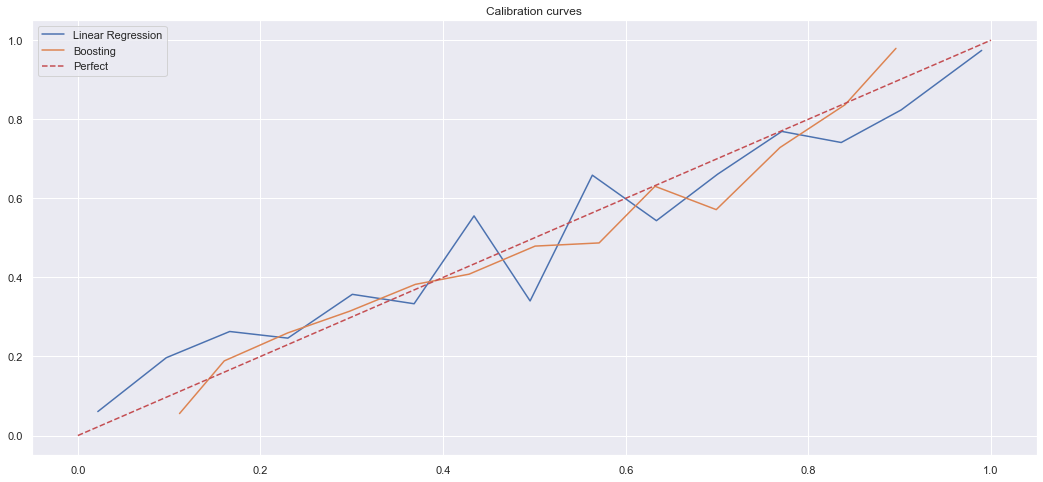

In [111]:
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression().fit(x_train, y_train)
preds_lr = model_lr.predict_proba(x_test)[:, 1]
lr_true_prob, lr_pred_prob = calibration_curve(y_test, preds_lr, n_bins=15)


model_gb = Boosting(**best_boost_my, base_model_params=best_tree_my)
model_gb.fit(x_train, y_train, x_valid, y_valid)
preds_gb = model_gb.predict_proba(x_test)[:, 1]
gb_true_prob, gb_pred_prob = calibration_curve(y_test, preds_gb, n_bins=15)

plt.figure(figsize=(18, 8))
plt.title('Calibration curves')
sns.lineplot(lr_pred_prob, lr_true_prob,label='Linear Regression')
sns.lineplot(gb_pred_prob, gb_true_prob, label='Boosting')
plt.plot([0, 1], [0, 1],'r--', label='Perfect')
plt.legend()
plt.xlabel('Mean predicted probability')
plt.ylabel('Positive share')
plt.show()

Теперь попробуем оценить важность признаков для бустинга.

Поскольку наша базовая модель - это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными - иначе вы что-то сделали не так).

Допишите в вашей реализации бустинга функцию `feature_importances_` чтобы она возвращала описанные выше важности признаков.

Нарисуйте столбчатую диаграмму важности признаков. На соседнем графике нарисуйте важность признаков для логистической регрессии, для этого используйте модули весов. Сравните графики. Проанализируйте полученные результаты.

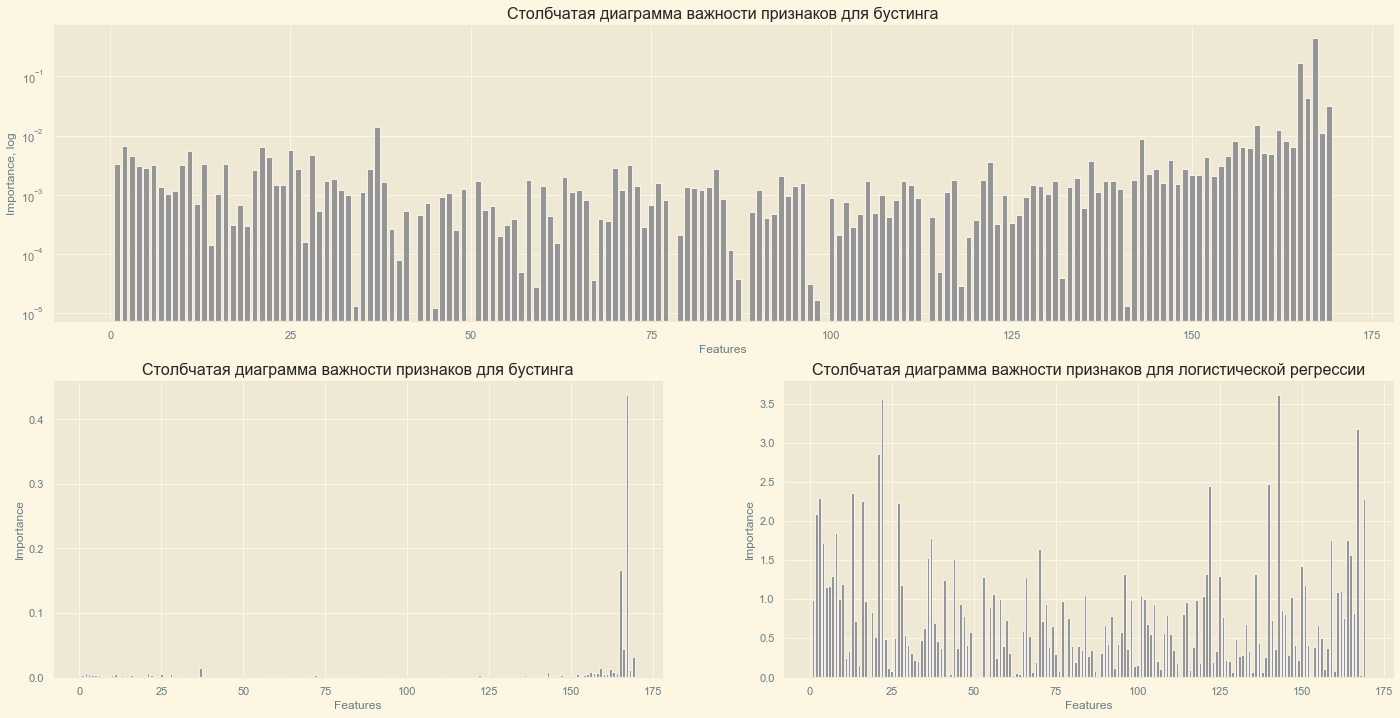

In [152]:
fig = plt.figure(1, figsize=(24,12))

ax = fig.add_subplot(2, 1, 1)

ax.bar(range(1, x_train.shape[1] + 1), model_gb.feature_importances_, color='gray', alpha=0.8)
ax.set_xlabel('Features')
ax.set_ylabel('Importance, log')
ax.set_title('Столбчатая диаграмма важности признаков для бустинга')
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 3)

ax.bar(range(1, x_train.shape[1] + 1), model_gb.feature_importances_, color='gray', alpha=0.8)
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Столбчатая диаграмма важности признаков для бустинга')

ax = fig.add_subplot(2, 2, 4)
ax.bar(range(1, x_train.shape[1] + 1), np.abs(model_lr.coef_.reshape(-1)), color='gray', alpha=0.8)
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Столбчатая диаграмма важности признаков для логистической регрессии')

plt.show()

Кстати, чаще всего излишние признаки могут вредить качеству бустинга. Попробуйте отфильтровать на основании диаграммы хвост наименее важных признаков и снова обучить модель (с теми же гиперпараметрами). Стало ли лучше?

In [182]:
indices = list(filter(lambda i: model_gb.feature_importances_[i] > 0.0005, range(x_train.shape[1])))
model_gb_f = Boosting(**best_boost_my, base_model_params=best_tree_my)
model_gb_f.fit(x_train[:, indices], y_train, x_valid[:, indices], y_valid)
print(model_gb_f.score(x_test[:, indices], y_test))

0.9373530796396918


## Задание 7 (бонус). Блендинговое (1 балл)

Реализуйте блендинг над вашими лучшими моделями (ваша реализация с лучшими гиперпараметрами + все модели из библиотек с лучшими гиперпараметрами). Улучшилось ли качество?

In [172]:
catboost_best = {'min_data_in_leaf': 1,
 'depth': 12,
 'iterations': 70,
 'learning_rate': 0.01,
 'boosting_type': 'Plain'}

level_0_model = [['my_boosting', Boosting(**best_boost_my, base_model_params=best_tree_my)],
                 ['cat_boosting', CatBoostClassifier(**catboost_best, logging_level='Silent')]]

In [173]:
def fit_ensemble(models, X_train, X_val, y_train, y_val):
    meta_X = list()
    for name, model in models:
        
        if name == 'my_boosting':
            model.fit(X_train, y_train, X_val, y_val)
        else:
            model.fit(X_train, y_train)

        yhat = model.predict_proba(X_val)[:, 1]
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
        
    meta_X = np.hstack(meta_X)
    blender = LogisticRegression()
    blender.fit(meta_X, y_val)
    return blender

In [183]:
def predict_ensemble(models, blender, X_test):
    meta_X = list()
    for name, model in models:
        yhat = model.predict_proba(X_test)[:, 1]
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
    return blender.predict(meta_X)

In [ ]:
blender = fit_ensemble(level_0_model, x_train, x_valid, y_train, y_valid)
yhat = predict_ensemble(level_0_model, blender, x_test)
score = roc_auc_score(y_test, yhat)

In [194]:
print('Blended')
print('ROC-AUC score on test for the Best combination is,',score)

Blended
ROC-AUC score on test for the Best combination is, 0.851994416829496


### References

1. https://machinelearningmastery.com/blending-ensemble-machine-learning-with-python/

2. https://github.com/optuna/optuna-examples/blob/main/catboost/catboost_simple.py

3. https://www.projectpro.io/recipes/find-optimal-parameters-for-catboost-using-gridsearchcv-for-regression

4. https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_grid_search

## Социализационный бонус. Новогоднее 🎆 (0.5 балла)

Сфотографируйтесь с наряженной новогодней или рождественской ёлкой! Приложите фотографию, опишите свои впечатления, чего вы ждете от нового 2022 года?